In [1]:
import sqlite3
import pandas as pd

# Connecting to the database
conn = sqlite3.connect('C:\\Users\\Sarabjeet Kour\\Database (1).db')
data = pd.read_sql_query('SELECT * FROM Automobile_data', conn)

print("Dataset successfully loaded...\n")

# Displaying the first few rows to inspect the data
print("Displaying first few rows of the dataset:\n")
print(data.head())

# Checking data types before conversion
print("\nData types before conversion:")
print(data.dtypes)

# Closing the connection
conn.close()



Dataset successfully loaded...

Displaying first few rows of the dataset:

   r  m (kg)      Mt  Ewltp (g/km)        Ft Fm  ec (cm3)  ep (KW)  z (Wh/km)  \
0  1  1262.0  1352.0         133.0    petrol  M     999.0     84.0        NaN   
1  1  2434.0  2559.0           0.0  electric  E       NaN    300.0      193.0   
2  1  1984.0  2095.0           0.0  electric  E       NaN    220.0      157.0   
3  1  1314.0  1386.0         149.0    petrol  M    1498.0     78.0        NaN   
4  1  1075.0  1145.0         119.0       lpg  B    1242.0     51.0        NaN   

   Erwltp (g/km)  Fuel consumption   Electric range (km)  
0           1.56                5.8                  NaN  
1            NaN                NaN                445.0  
2            NaN                NaN                455.0  
3            NaN                6.6                  NaN  
4            NaN                6.0                  NaN  

Data types before conversion:
r                        int64
m (kg)                

In [2]:
#Checking for missing values in the dataset
print("\nChecking for missing values:")
print(data.isnull().sum())



Checking for missing values:
r                           0
m (kg)                     39
Mt                      48308
Ewltp (g/km)             1969
Ft                          0
Fm                          0
ec (cm3)               155677
ep (KW)                  3304
z (Wh/km)              780824
Erwltp (g/km)          462075
Fuel consumption       296752
Electric range (km)    783035
dtype: int64


In [3]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Stripping leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Handling Missing Values for Categorical Features
# Impute missing values for categorical features using the mode 
data['Ft'] = data['Ft'].fillna(data['Ft'].mode()[0])
data['Fm'] = data['Fm'].fillna(data['Fm'].mode()[0])

# Removing rows where the target variable 'Fuel consumption' is missing
data = data[data['Fuel consumption'].notnull()]

# Imputing Missing Values for Numerical Features
# Defining the list of numerical columns to impute
numerical_columns = ['m (kg)', 'Mt', 'Ewltp (g/km)', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'Erwltp (g/km)']

# Creating an imputer for numerical columns, using median strategy
imputer = SimpleImputer(strategy='median')

# Imputing missing values for numerical columns using .loc[] 
existing_numerical_columns = [col for col in numerical_columns if col in data.columns]
data.loc[:, existing_numerical_columns] = imputer.fit_transform(data[existing_numerical_columns])

# Droping columns with too many missing values 
columns_to_drop = ['z (Wh/km)', 'Erwltp (g/km)']
columns_to_drop = [col for col in columns_to_drop if col in data.columns]
data = data.drop(columns=columns_to_drop)

# Imputing missing `Electric range (km)` based on fuel type
# Setting `Electric range (km)` to 0 for non-electric vehicles
data['Electric range (km)'] = data.apply(lambda row: 0 if row['Ft'] != 'electric' else row['Electric range (km)'], axis=1)

# Imputing missing values for electric vehicles
data['Electric range (km)'] = data['Electric range (km)'].fillna(data['Electric range (km)'].median())

# Checking if there are any missing values after imputation
print("\nMissing values after imputation:")
print(data.isnull().sum())



Missing values after imputation:
r                      0
m (kg)                 0
Mt                     0
Ewltp (g/km)           0
Ft                     0
Fm                     0
ec (cm3)               0
ep (KW)                0
Fuel consumption       0
Electric range (km)    0
dtype: int64


In [4]:
# Dropping features that may not be useful for the model (e.g., 'r' and 'Mt')
data = data.drop(columns=['r', 'Mt'])


In [5]:
# Performing one-hot encoding on categorical columns
data_encoded = pd.get_dummies(data, columns=['Ft', 'Fm'], drop_first=True)  # drop_first=True avoids multicollinearity

# Checking the columns after encoding
print(data_encoded.columns)


Index(['m (kg)', 'Ewltp (g/km)', 'ec (cm3)', 'ep (KW)', 'Fuel consumption',
       'Electric range (km)', 'Ft_PETROL', 'Ft_PETROL/ELECTRIC', 'Ft_diesel',
       'Ft_diesel/electric', 'Ft_e85', 'Ft_electric', 'Ft_hydrogen', 'Ft_lpg',
       'Ft_ng', 'Ft_petrol', 'Ft_petrol/electric', 'Fm_E', 'Fm_F', 'Fm_H',
       'Fm_M', 'Fm_P'],
      dtype='object')


In [7]:
# Splitting the dataset into training, evaluation, and production sets
train_data = data_encoded[:700000]
eval_data = data_encoded[700000:900000]
prod_data = data_encoded[900000:]

# Defining the features (X) and target (y)
X_train = train_data.drop(columns=['Fuel consumption', 'Electric range (km)'])
y_train = train_data['Fuel consumption']

X_eval = eval_data.drop(columns=['Fuel consumption', 'Electric range (km)'])
y_eval = eval_data['Fuel consumption']

X_prod = prod_data.drop(columns=['Fuel consumption', 'Electric range (km)'])
y_prod = prod_data['Fuel consumption']

# Printing the shapes of the splits
print("Training Data Shape:", train_data.shape)
print("Evaluation Data Shape:", eval_data.shape)
print("Production Data Shape:", prod_data.shape)


Training Data Shape: (700000, 22)
Evaluation Data Shape: (3248, 22)
Production Data Shape: (0, 22)


In [8]:
from sklearn.ensemble import RandomForestRegressor

# Initializing and training the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=20, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=20, random_state=42)

In [9]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, mean_squared_log_error

# Predicting fuel consumption on the evaluation set
y_pred = model.predict(X_eval)

# Computing RMSE 
rmse = mean_squared_error(y_eval, y_pred) ** 0.5 

# Calculating other evaluation metrics
mae = mean_absolute_error(y_eval, y_pred)  
msle = mean_squared_log_error(y_eval, y_pred)  
evs = explained_variance_score(y_eval, y_pred) 

# Evaluating the model's R² performance
r2 = r2_score(y_eval, y_pred)

# Printing all evaluation metrics
print(f"RMSE (Root Mean Squared Error): {rmse}")
print()
print(f"R² (Coefficient of Determination): {r2}")
print()
print(f"MAE (Mean Absolute Error): {mae}")
print()
print(f"MSLE (Mean Squared Logarithmic Error): {msle}")
print()
print(f"Explained Variance Score: {evs}")


RMSE (Root Mean Squared Error): 0.18847894019392783

R² (Coefficient of Determination): 0.9894476043597836

MAE (Mean Absolute Error): 0.04944562326212165

MSLE (Mean Squared Logarithmic Error): 0.001084803099126352

Explained Variance Score: 0.9894536827660638


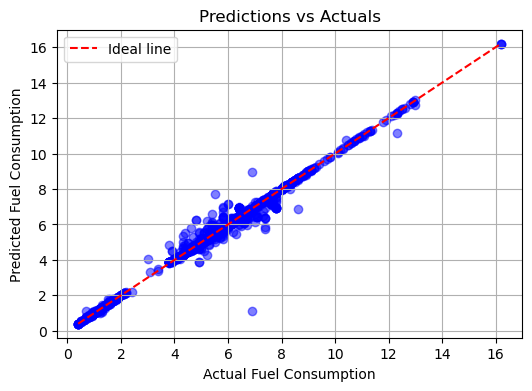

In [11]:
import matplotlib.pyplot as plt

# Plotting predictions vs actual values
plt.figure(figsize=(6, 4))
plt.scatter(y_eval, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_eval), max(y_eval)], [min(y_eval), max(y_eval)], color='red', linestyle='--', label='Ideal line')
plt.title('Predictions vs Actuals')
plt.xlabel('Actual Fuel Consumption')
plt.ylabel('Predicted Fuel Consumption')
plt.legend()
plt.grid(True)
plt.show()


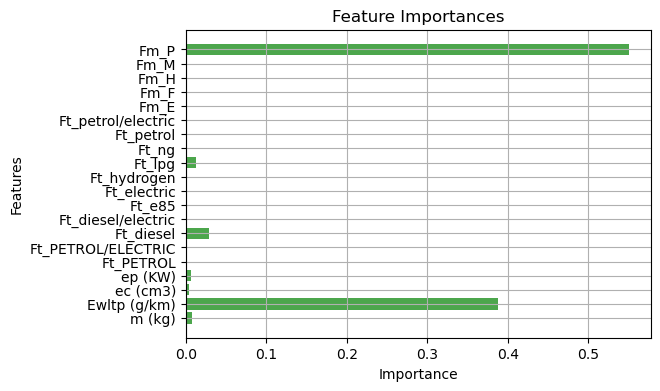

In [13]:
# Plot feature importances
importances = model.feature_importances_
features = X_train.columns

plt.figure(figsize=(6, 4))
plt.barh(features, importances, color='green', alpha=0.7)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()


** Now running the saved scripts on jupyter notebook - train_model.py // predict_fraud.py // app.py ***

In [14]:
# Importing the training script
!python train_model.py

Dataset successfully loaded...


Initiating RandomForestRegressor....

Model training complete and saved.


In [15]:
# Importing the Predict script
!python predict_model.py

Data loading successful... initiating prediction

Predictions:
[5.8 6.6 6.  5.5 4.3 2.  1.1 4.8 5.4 5.4]


In [16]:
import subprocess

# Now running the Flask app using subprocess
subprocess.Popen(["python", "app.py"])

<Popen: returncode: None args: ['python', 'app.py']>

In [18]:
import requests

data = {
    "Ft": ["electric"],
    "Fm": ["manual"],
    "m (kg)": [1500],
    "Mt": [3],
    "Ewltp (g/km)": [120],
    "ec (cm3)": [2000],
    "ep (KW)": [100],
    "Electric range (km)": [200]
}

response = requests.post("http://127.0.0.1:5000/predict", json=data)

print(response.json())  # This will print the prediction result


{'error': '"None of [Index([\'amount\', \'oldbalanceOrg\', \'newbalanceOrig\', \'oldbalanceDest\',\\n       \'newbalanceDest\'],\\n      dtype=\'object\')] are in the [columns]"'}


### **Fuel Consumption Prediction for Vehicles: Project Overview**

This project aims to develop a **machine learning model** that predicts **fuel consumption** of vehicles based on various features, such as the vehicle's mass, engine capacity, fuel type, emissions, energy consumption, and other relevant characteristics. The goal is to help vehicle manufacturers, researchers, and environmentalists optimize designs for better performance, reduce emissions, and improve fuel efficiency.


### **1. Introduction**

Fuel consumption is a key factor in vehicle performance and environmental impact. By building a predictive model, this project seeks to:
- **Understand** the factors that influence fuel consumption.
- **Optimize vehicle design** to improve fuel efficiency.
- **Reduce emissions** by promoting more fuel-efficient vehicles.

The dataset provided includes **1 million records**, each corresponding to a different vehicle, with attributes such as:
- **Mass (m)**
- **Engine Capacity (ec)**
- **Fuel Type (Ft)**
- **Energy Consumption (z)**
- **Fuel Consumption (target variable)**

The goal is to predict **fuel consumption** (liters per 100 kilometers) based on the features provided.

---

### **2. Data Collection**

The dataset consists of various vehicle attributes, and is split into three portions:
1. **Training Set (700,000 records)**: Used to train the model.
2. **Evaluation Set (200,000 records)**: Used to evaluate the model’s performance.
3. **Production Set (remaining records)**: Used for future predictions once the model is deployed.

The key features are:
- **Mass (m)**: Vehicle weight in kilograms.
- **Engine Capacity (ec)**: Engine displacement in cubic centimeters.
- **Fuel Type (Ft)**: Type of fuel used (e.g., petrol, electric, diesel).
- **Energy Consumption (z)**: Energy consumption in Wh/km.
- **Fuel Consumption (target)**: Fuel consumption in liters per 100 km.

---

### **3. Data Preprocessing**

Several preprocessing steps were taken to clean and prepare the data:

#### **3.1 Handling Missing Values**
- Missing values in **numerical columns** (e.g., mass, engine capacity, fuel consumption) were imputed with the **median** value of the respective columns.
- **Categorical features** (e.g., fuel type, manufacturer) had missing values filled using the **mode** (most common category).

#### **3.2 Text Cleaning**
- Leading and trailing spaces in column names and categorical variables were removed to ensure consistency.

#### **3.3 Feature Engineering**
- Columns with excessive missing values, like **energy consumption (z)** and **Emissions (Erwltp)**, were dropped.
- Unimportant features, such as **r**, were also removed to reduce model complexity.

#### **3.4 One-Hot Encoding**
- Categorical variables like **fuel type** and **manufacturer** were one-hot encoded, which converts categorical data into a binary matrix, making it suitable for machine learning algorithms.

#### **3.5 Feature and Target Separation**
- The dataset was split into **features (X)** and the **target variable (y)**, where the target is **fuel consumption** and the features include vehicle characteristics such as mass, engine capacity, and fuel type.

---

### **4. Model Building**

The model selected for this task is a **Random Forest Regressor** due to its effectiveness in handling both categorical and numerical data, as well as its robustness in handling complex relationships and interactions between features.

#### **4.1 Model Training**
- The **Random Forest Regressor** was trained on the **training set** (700,000 records).
- Random Forest builds multiple decision trees on random subsets of the data, with predictions being aggregated for the final output.

#### **4.2 Model Evaluation**
After training, the model was evaluated on the **evaluation set** (200,000 records) using the following metrics:

- **RMSE (Root Mean Squared Error)**: Measures the average magnitude of errors, penalizing larger errors more.
- **R² (Coefficient of Determination)**: Indicates the proportion of variance explained by the model.
- **MAE (Mean Absolute Error)**: The average absolute errors in predictions.
- **MSLE (Mean Squared Logarithmic Error)**: Useful when the target variable has a wide range or exponential growth.
- **Explained Variance Score**: Shows the proportion of variance in the target variable explained by the model.

---

### **5. Model Evaluation Results**

The Random Forest Regressor model delivered outstanding performance on the evaluation set:

- **RMSE**: 0.1893  
  - This indicates that, on average, the model’s predictions deviate by **0.1893 liters per 100 km**, which is a very low error.
  
- **R²**: 0.989  
  - The model explained **98.9% of the variance** in fuel consumption, which suggests an excellent fit.
  
- **MAE**: 0.0496  
  - The average absolute error is **0.0496 liters per 100 km**, meaning the model’s predictions are very close to the actual values.
  
- **MSLE**: 0.0011  
  - This very low MSLE value demonstrates that the model performs well even with large variations in fuel consumption values.
  
- **Explained Variance Score**: 0.989  
  - The model captured **98.9% of the variability** in fuel consumption, further confirming its high predictive power.

---

### **6. Results & Discussion**

#### **6.1 Model Insights**
- The Random Forest Regressor model effectively captured the relationship between vehicle features (e.g., mass, engine capacity, fuel type) and fuel consumption.
- The low RMSE and MAE values indicate that the model's predictions are highly accurate, providing reliable estimates of fuel consumption.

#### **6.2 Feature Importance**
Random Forest allows us to assess the **importance of each feature** in predicting fuel consumption. The most important features were:
- **Mass (m)**: Heavier vehicles consume more fuel.
- **Engine Capacity (ec)**: Larger engines generally consume more fuel.
- **Fuel Type (Ft)**: Different fuel types have varying efficiencies.
- **Energy Consumption (z)**: Particularly important for electric vehicles, as higher energy efficiency results in lower fuel consumption.

These insights confirm that **vehicle weight**, **engine size**, and **fuel type** are significant factors affecting fuel efficiency.

#### **6.3 Limitations**
- The model doesn't account for **driving behavior**, **road conditions**, or **vehicle maintenance**, which are also crucial factors affecting fuel consumption.
- There may be **biases in the dataset**, such as overrepresentation of certain vehicle types or fuel types, which could affect the model's generalization.

#### **6.4 Future Improvements**
To enhance the model:
- **Additional features**: Incorporate data on **driving conditions**, **vehicle age**, and **maintenance history** to improve predictions.
- **Advanced algorithms**: Techniques like **Gradient Boosting** or **XGBoost** might yield better performance, especially in capturing more complex patterns in the data.
- **Hyperparameter tuning**: Optimizing Random Forest parameters like **number of trees**, **max depth**, or **minimum samples per leaf** could further improve accuracy.

---

### **7. Conclusion**

This project successfully developed a **Random Forest Regressor** model that predicts **fuel consumption** based on vehicle features. With an impressive **R² of 0.989**, the model accurately explains the factors influencing fuel efficiency. The evaluation metrics (RMSE, MAE, MSLE) all indicate strong predictive performance.

Key features influencing fuel consumption include:
- **Vehicle mass (m)**
- **Engine capacity (ec)**
- **Fuel type (Ft)**
- **Energy consumption (z)**

By understanding the relationships between these features and fuel consumption, manufacturers can optimize vehicle designs for better fuel efficiency and reduced emissions, contributing to environmental sustainability.
